In [1]:
import pandas as pd
import torch
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    RobertaTokenizer,
    RobertaForSequenceClassification,
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
)
from sklearn.model_selection import train_test_split
from datasets import Dataset
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from transformers import DataCollatorWithPadding
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_fscore_support,
)
import seaborn as sns

## Loading/exploring the data

In [80]:
df = pd.read_csv("./data/final_data.csv")
df = df[["text", "og_label", "LABEL"]]
# i want it to be called phrase, label for column names
df = df.rename(columns={"text": "phrase", "LABEL": "label"})
df.head()

,phrase,og_label,label
0,When I remember her I feel down,Emotional pain,Neurological & General Symptoms
1,When I carry heavy things I feel like breaking...,Hair falling out,Dermatological & Skin Conditions
2,there is too much pain when i move my arm,Heart hurts,Chronic Conditions
3,My son had his lip pierced and it is swollen a...,Infected wound,Infections
4,My muscles in my lower back are aching,Infected wound,Infections


phrase and label will be the columns used in the model below

In [3]:
df.shape

(2306, 3)

In [4]:
df["label"].value_counts()

label
Infections                                     364
Dermatological & Skin Conditions               346
Chronic Conditions                             297
Pain & Injuries                                295
Respiratory & Sensory Issues                   241
Gastrointestinal & Hepatobiliary Conditions    178
Neurological & General Symptoms                130
Allergic/Immunologic Reactions                 101
Name: count, dtype: int64

In [5]:
df = df.drop("og_label", axis=1)

In [6]:
# because i didnt totally finish mapping in data_manipulation.ipynb, there are some NaNs so dropping them here
df.dropna(subset=["label"], inplace=True)

In [7]:
missing_any = df[df.isnull().any(axis=1)]
print(missing_any)

Empty DataFrame
Columns: [phrase, label]
Index: []


## Preprocess data

In [8]:
# this creates an integer for each label
# creates column label_id with the number label for each of the labels

unique_labels = df["label"].unique().tolist()
label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for label, i in label2id.items()}

df["label_id"] = df["label"].map(label2id)
df.head()

,phrase,label,label_id
0,When I remember her I feel down,Neurological & General Symptoms,0
1,When I carry heavy things I feel like breaking...,Dermatological & Skin Conditions,1
2,there is too much pain when i move my arm,Chronic Conditions,2
3,My son had his lip pierced and it is swollen a...,Infections,3
4,My muscles in my lower back are aching,Infections,3


In [9]:
# train, test, validation split
# adjust to 80/20 or whatever as needed
train_df_og, test_df = train_test_split(df, test_size=0.20, random_state=42)
train_df, val_df = train_test_split(train_df_og, test_size=0.20, random_state=42)

In [10]:
# now coverting the pandas dataframes into Hugging Face dataset objects
train_dataset_OG = Dataset.from_pandas(train_df[["phrase", "label_id"]])
val_dataset_OG = Dataset.from_pandas(val_df[["phrase", "label_id"]])
test_dataset_OG = Dataset.from_pandas(test_df[["phrase", "label_id"]])

whole_dataset_OG = Dataset.from_pandas(df[["phrase", "label_id"]])

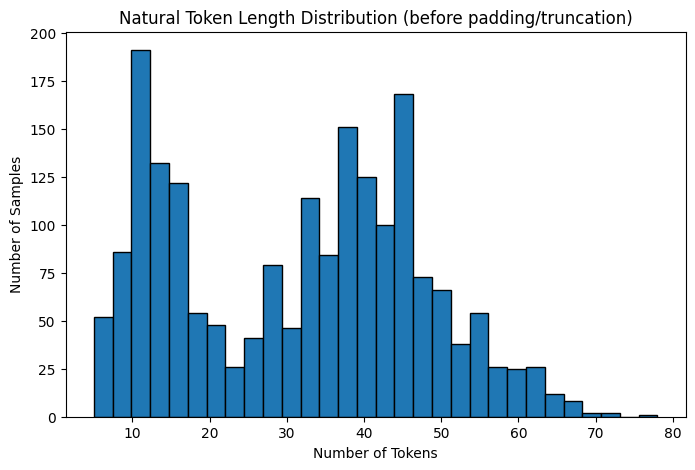

In [11]:
from transformers import BertTokenizer
import matplotlib.pyplot as plt

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Use the raw text data (e.g., from train_dataset_OG)
token_lengths = [
    len(tokenizer.encode(x["phrase"], add_special_tokens=True))
    for x in whole_dataset_OG
]

# Plot it
plt.figure(figsize=(8, 5))
plt.hist(token_lengths, bins=30, edgecolor="black")
plt.title("Natural Token Length Distribution (before padding/truncation)")
plt.xlabel("Number of Tokens")
plt.ylabel("Number of Samples")
plt.show()

# BERT-base

## Tokenize the Text

In [12]:
tokenizer_bert = BertTokenizer.from_pretrained("bert-base-uncased")


def tokenize_function(example):
    return tokenizer(example["phrase"], padding=True, truncation=True)

In [13]:
# apply the tokenizer to our data
train_dataset_bert = train_dataset_OG.map(tokenize_function, batched=True)
val_dataset_bert = val_dataset_OG.map(tokenize_function, batched=True)
test_dataset_bert = test_dataset_OG.map(tokenize_function, batched=True)

# rename columns to the format Trainer expects
train_dataset_bert = train_dataset_bert.rename_column("label_id", "labels")
val_dataset_bert = val_dataset_bert.rename_column("label_id", "labels")
test_dataset_bert = test_dataset_bert.rename_column("label_id", "labels")

# set format to PyTorch tensors
train_dataset_bert.set_format(
    "torch", columns=["input_ids", "attention_mask", "labels"]
)
val_dataset_bert.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset_bert.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/1248 [00:00<?, ? examples/s]

Map:   0%|          | 0/313 [00:00<?, ? examples/s]

Map:   0%|          | 0/391 [00:00<?, ? examples/s]

## Define the Model

In [14]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(unique_labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training


In [15]:
# defining the training hyperparams
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",  # Evaluate every epoch
    save_strategy="epoch",  # Save checkpoint every epoch
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,  # Adjust based on dataset size
    weight_decay=0.01,
    logging_steps=50,
)


# evaluation function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")
    return {"accuracy": acc, "f1": f1}


data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
# for paddinf

# initialize the trainer
trainer_bertbase = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_bert,
    eval_dataset=val_dataset_bert,
    tokenizer=tokenizer_bert,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

# now we actually trian
trainer_bertbase.train()

/Users/kaylahaeusssler/miniforge3/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/bs/tlrmg2n164520pry59rs7fvh0000gn/T/ipykernel_50087/2425874495.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_bertbase = Trainer(


  0%|          | 0/780 [00:00<?, ?it/s]

{'loss': 1.7854, 'grad_norm': 10.141824722290039, 'learning_rate': 4.67948717948718e-05, 'epoch': 0.32}
{'loss': 1.2446, 'grad_norm': 11.115766525268555, 'learning_rate': 4.358974358974359e-05, 'epoch': 0.64}
{'loss': 0.7915, 'grad_norm': 8.401602745056152, 'learning_rate': 4.038461538461539e-05, 'epoch': 0.96}


  0%|          | 0/40 [00:00<?, ?it/s]

{'eval_loss': 0.6148484945297241, 'eval_accuracy': 0.8083067092651757, 'eval_f1': 0.7997451901607793, 'eval_runtime': 1.2296, 'eval_samples_per_second': 254.562, 'eval_steps_per_second': 32.532, 'epoch': 1.0}
{'loss': 0.499, 'grad_norm': 18.01125717163086, 'learning_rate': 3.717948717948718e-05, 'epoch': 1.28}
{'loss': 0.4022, 'grad_norm': 5.610483169555664, 'learning_rate': 3.397435897435898e-05, 'epoch': 1.6}
{'loss': 0.2623, 'grad_norm': 10.755924224853516, 'learning_rate': 3.0769230769230774e-05, 'epoch': 1.92}


  0%|          | 0/40 [00:00<?, ?it/s]

{'eval_loss': 0.3613031506538391, 'eval_accuracy': 0.9009584664536742, 'eval_f1': 0.9004842995556989, 'eval_runtime': 1.0948, 'eval_samples_per_second': 285.894, 'eval_steps_per_second': 36.536, 'epoch': 2.0}
{'loss': 0.1614, 'grad_norm': 1.7046308517456055, 'learning_rate': 2.756410256410257e-05, 'epoch': 2.24}
{'loss': 0.0506, 'grad_norm': 2.0826308727264404, 'learning_rate': 2.435897435897436e-05, 'epoch': 2.56}
{'loss': 0.1763, 'grad_norm': 0.24756436049938202, 'learning_rate': 2.1153846153846154e-05, 'epoch': 2.88}


  0%|          | 0/40 [00:00<?, ?it/s]

{'eval_loss': 0.4158254861831665, 'eval_accuracy': 0.9169329073482428, 'eval_f1': 0.9167699352454604, 'eval_runtime': 1.1087, 'eval_samples_per_second': 282.325, 'eval_steps_per_second': 36.08, 'epoch': 3.0}
{'loss': 0.0504, 'grad_norm': 1.1784770488739014, 'learning_rate': 1.794871794871795e-05, 'epoch': 3.21}
{'loss': 0.0686, 'grad_norm': 0.08016516268253326, 'learning_rate': 1.4743589743589745e-05, 'epoch': 3.53}
{'loss': 0.0678, 'grad_norm': 0.09287659078836441, 'learning_rate': 1.153846153846154e-05, 'epoch': 3.85}


  0%|          | 0/40 [00:00<?, ?it/s]

{'eval_loss': 0.418910413980484, 'eval_accuracy': 0.9041533546325878, 'eval_f1': 0.9038028179319726, 'eval_runtime': 1.1254, 'eval_samples_per_second': 278.123, 'eval_steps_per_second': 35.543, 'epoch': 4.0}
{'loss': 0.0067, 'grad_norm': 0.18469661474227905, 'learning_rate': 8.333333333333334e-06, 'epoch': 4.17}
{'loss': 0.0258, 'grad_norm': 0.056891798973083496, 'learning_rate': 5.128205128205128e-06, 'epoch': 4.49}
{'loss': 0.015, 'grad_norm': 0.6547477841377258, 'learning_rate': 1.9230769230769234e-06, 'epoch': 4.81}


  0%|          | 0/40 [00:00<?, ?it/s]

{'eval_loss': 0.4134918451309204, 'eval_accuracy': 0.9137380191693291, 'eval_f1': 0.9134138488164462, 'eval_runtime': 1.1309, 'eval_samples_per_second': 276.776, 'eval_steps_per_second': 35.371, 'epoch': 5.0}
{'train_runtime': 104.5881, 'train_samples_per_second': 59.663, 'train_steps_per_second': 7.458, 'train_loss': 0.3610438287258148, 'epoch': 5.0}


TrainOutput(global_step=780, training_loss=0.3610438287258148, metrics={'train_runtime': 104.5881, 'train_samples_per_second': 59.663, 'train_steps_per_second': 7.458, 'total_flos': 234099227681280.0, 'train_loss': 0.3610438287258148, 'epoch': 5.0})

In [16]:
bertbaselog = pd.DataFrame(trainer_bertbase.state.log_history)

## Evaluate and Testing

In [17]:
# Training logs: rows that have a "loss" value (they won't have eval metrics)
train_logs = bertbaselog[bertbaselog["loss"].notna()]

# Evaluation logs: rows that have evaluation metrics (e.g., eval_loss)
eval_logs = bertbaselog[bertbaselog["eval_loss"].notna()]

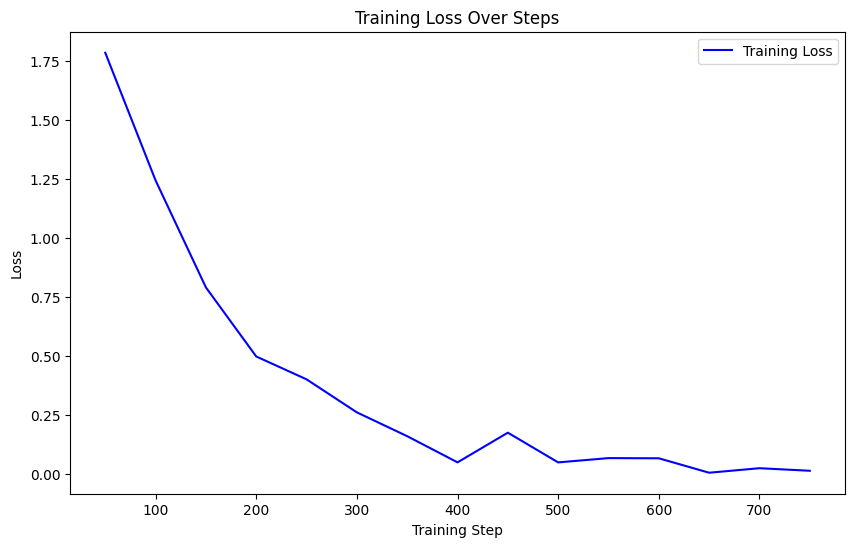

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(train_logs["step"], train_logs["loss"], label="Training Loss", color="blue")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training Loss Over Steps")
plt.legend()
plt.show()

maybe put these on same plot and see if something diff going on

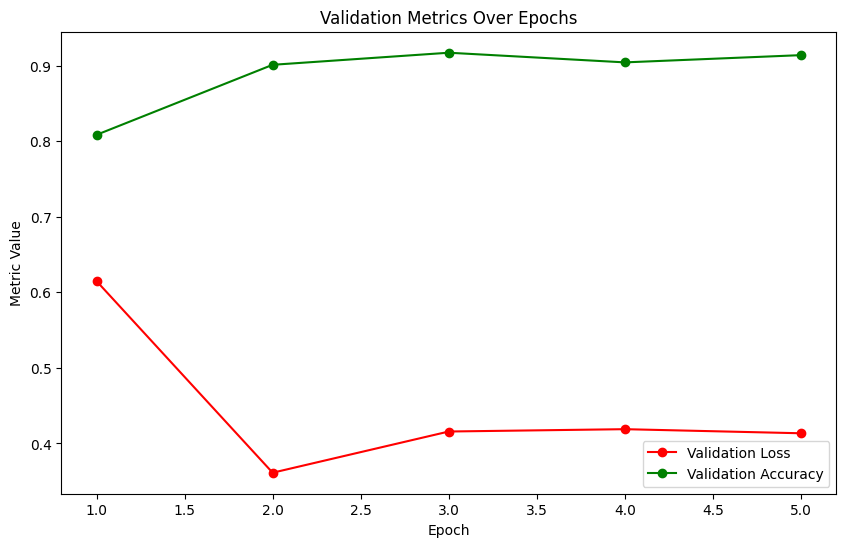

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(
    eval_logs["epoch"],
    eval_logs["eval_loss"],
    marker="o",
    label="Validation Loss",
    color="red",
)
plt.plot(
    eval_logs["epoch"],
    eval_logs["eval_accuracy"],
    marker="o",
    label="Validation Accuracy",
    color="green",
)
plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.title("Validation Metrics Over Epochs")
plt.legend()
plt.show()

val los bert and roberta one plot
val accuracy bert and roberta one plot

In [20]:
# Evaluate on validation set
val_metrics = trainer_bertbase.evaluate(eval_dataset=val_dataset_bert)
print("Validation metrics:", val_metrics)

# Evaluate on test set
test_metrics = trainer_bertbase.evaluate(eval_dataset=test_dataset_bert)
print("Test metrics:", test_metrics)

  0%|          | 0/40 [00:00<?, ?it/s]

Validation metrics: {'eval_loss': 0.4134918451309204, 'eval_accuracy': 0.9137380191693291, 'eval_f1': 0.9134138488164462, 'eval_runtime': 1.1818, 'eval_samples_per_second': 264.848, 'eval_steps_per_second': 33.846, 'epoch': 5.0}


  0%|          | 0/49 [00:00<?, ?it/s]

Test metrics: {'eval_loss': 0.3427284061908722, 'eval_accuracy': 0.9104859335038363, 'eval_f1': 0.9107985758401863, 'eval_runtime': 1.7187, 'eval_samples_per_second': 227.491, 'eval_steps_per_second': 28.509, 'epoch': 5.0}


  0%|          | 0/40 [00:00<?, ?it/s]

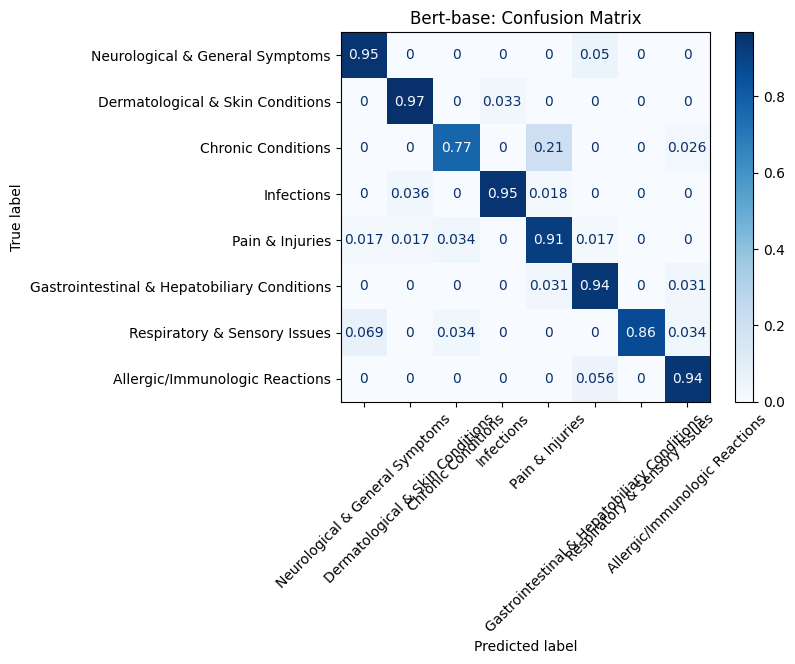

In [21]:
# Run the model on the validation set
predictions = trainer_bertbase.predict(val_dataset_bert)

# Get predicted and true labels
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Create the confusion matrix
cm_bertbase = confusion_matrix(y_true, y_pred, normalize="true")
# normalize = true shows proportions instead of raw numbers

# Plot it
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_bertbase, display_labels=unique_labels
)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Bert-base: Confusion Matrix")
plt.show()

# ROBERTA

## Tokenize the Text

In [56]:
tokenizer_roberta = RobertaTokenizer.from_pretrained("roberta-base")


def tokenize_function_roberta(example):
    return tokenizer_roberta(example["phrase"], padding=True, truncation=True)

In [57]:
# apply the tokenizer to our data
train_dataset_roberta = train_dataset_OG.map(tokenize_function_roberta, batched=True)
val_dataset_roberta = val_dataset_OG.map(tokenize_function_roberta, batched=True)
test_dataset_roberta = test_dataset_OG.map(tokenize_function_roberta, batched=True)

# rename columns to the format Trainer expects
train_dataset_roberta = train_dataset_roberta.rename_column("label_id", "labels")
val_dataset_roberta = val_dataset_roberta.rename_column("label_id", "labels")
test_dataset_roberta = test_dataset_roberta.rename_column("label_id", "labels")

# set format to PyTorch tensors
train_dataset_roberta.set_format(
    "torch", columns=["input_ids", "attention_mask", "labels"]
)
val_dataset_roberta.set_format(
    "torch", columns=["input_ids", "attention_mask", "labels"]
)
test_dataset_roberta.set_format(
    "torch", columns=["input_ids", "attention_mask", "labels"]
)

Map:   0%|          | 0/1248 [00:00<?, ? examples/s]

Map:   0%|          | 0/313 [00:00<?, ? examples/s]

Map:   0%|          | 0/391 [00:00<?, ? examples/s]

## Define the Model

In [58]:
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=len(unique_labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training

In [59]:
# defining the training hyperparams
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",  # Evaluate every epoch
    save_strategy="epoch",  # Save checkpoint every epoch
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,  # Adjust based on dataset size
    weight_decay=0.01,
    logging_steps=50,
)


# evaluation function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")
    return {"accuracy": acc, "f1": f1}


# initialize the trainer
trainer_roberta = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_roberta,
    eval_dataset=val_dataset_roberta,
    tokenizer=tokenizer_roberta,
    compute_metrics=compute_metrics,
)

# now we actually trian
trainer_roberta.train()

/Users/kaylahaeusssler/miniforge3/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/bs/tlrmg2n164520pry59rs7fvh0000gn/T/ipykernel_50087/4072026974.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_roberta = Trainer(


  0%|          | 0/780 [00:00<?, ?it/s]

{'loss': 1.7521, 'grad_norm': 18.946680068969727, 'learning_rate': 4.67948717948718e-05, 'epoch': 0.32}
{'loss': 1.1996, 'grad_norm': 32.27735900878906, 'learning_rate': 4.358974358974359e-05, 'epoch': 0.64}
{'loss': 0.8595, 'grad_norm': 10.958382606506348, 'learning_rate': 4.038461538461539e-05, 'epoch': 0.96}


  0%|          | 0/40 [00:00<?, ?it/s]

{'eval_loss': 0.6657484769821167, 'eval_accuracy': 0.7891373801916933, 'eval_f1': 0.7637501128720597, 'eval_runtime': 1.2915, 'eval_samples_per_second': 242.359, 'eval_steps_per_second': 30.972, 'epoch': 1.0}
{'loss': 0.6426, 'grad_norm': 5.348456382751465, 'learning_rate': 3.717948717948718e-05, 'epoch': 1.28}
{'loss': 0.5124, 'grad_norm': 3.4492576122283936, 'learning_rate': 3.397435897435898e-05, 'epoch': 1.6}
{'loss': 0.3425, 'grad_norm': 15.12332820892334, 'learning_rate': 3.0769230769230774e-05, 'epoch': 1.92}


  0%|          | 0/40 [00:00<?, ?it/s]

{'eval_loss': 0.45662403106689453, 'eval_accuracy': 0.8722044728434505, 'eval_f1': 0.8705559433731487, 'eval_runtime': 1.1541, 'eval_samples_per_second': 271.202, 'eval_steps_per_second': 34.658, 'epoch': 2.0}
{'loss': 0.2394, 'grad_norm': 1.9799350500106812, 'learning_rate': 2.756410256410257e-05, 'epoch': 2.24}
{'loss': 0.1328, 'grad_norm': 38.52944564819336, 'learning_rate': 2.435897435897436e-05, 'epoch': 2.56}
{'loss': 0.2947, 'grad_norm': 0.39020848274230957, 'learning_rate': 2.1153846153846154e-05, 'epoch': 2.88}


  0%|          | 0/40 [00:00<?, ?it/s]

{'eval_loss': 0.4698861837387085, 'eval_accuracy': 0.8913738019169329, 'eval_f1': 0.8912155086156069, 'eval_runtime': 1.1299, 'eval_samples_per_second': 277.025, 'eval_steps_per_second': 35.403, 'epoch': 3.0}
{'loss': 0.0864, 'grad_norm': 42.998992919921875, 'learning_rate': 1.794871794871795e-05, 'epoch': 3.21}
{'loss': 0.1226, 'grad_norm': 73.66792297363281, 'learning_rate': 1.4743589743589745e-05, 'epoch': 3.53}
{'loss': 0.1058, 'grad_norm': 0.09978172183036804, 'learning_rate': 1.153846153846154e-05, 'epoch': 3.85}


  0%|          | 0/40 [00:00<?, ?it/s]

{'eval_loss': 0.5525894165039062, 'eval_accuracy': 0.8945686900958466, 'eval_f1': 0.894685244570887, 'eval_runtime': 1.1349, 'eval_samples_per_second': 275.795, 'eval_steps_per_second': 35.245, 'epoch': 4.0}
{'loss': 0.0228, 'grad_norm': 14.77159309387207, 'learning_rate': 8.333333333333334e-06, 'epoch': 4.17}
{'loss': 0.0522, 'grad_norm': 0.07268326729536057, 'learning_rate': 5.128205128205128e-06, 'epoch': 4.49}
{'loss': 0.0734, 'grad_norm': 9.977766036987305, 'learning_rate': 1.9230769230769234e-06, 'epoch': 4.81}


  0%|          | 0/40 [00:00<?, ?it/s]

{'eval_loss': 0.49752384424209595, 'eval_accuracy': 0.9137380191693291, 'eval_f1': 0.9133080640980651, 'eval_runtime': 1.1582, 'eval_samples_per_second': 270.254, 'eval_steps_per_second': 34.537, 'epoch': 5.0}
{'train_runtime': 102.2356, 'train_samples_per_second': 61.036, 'train_steps_per_second': 7.629, 'train_loss': 0.4163886311726692, 'epoch': 5.0}


TrainOutput(global_step=780, training_loss=0.4163886311726692, metrics={'train_runtime': 102.2356, 'train_samples_per_second': 61.036, 'train_steps_per_second': 7.629, 'total_flos': 218065034004480.0, 'train_loss': 0.4163886311726692, 'epoch': 5.0})

In [60]:
robertalog = pd.DataFrame(trainer_roberta.state.log_history)

## Evaluate and Testing

In [61]:
# Training logs: rows that have a "loss" value (they won't have eval metrics)
roberta_train_logs = robertalog[robertalog["loss"].notna()]

# Evaluation logs: rows that have evaluation metrics (e.g., eval_loss)
roberta_eval_logs = robertalog[robertalog["eval_loss"].notna()]

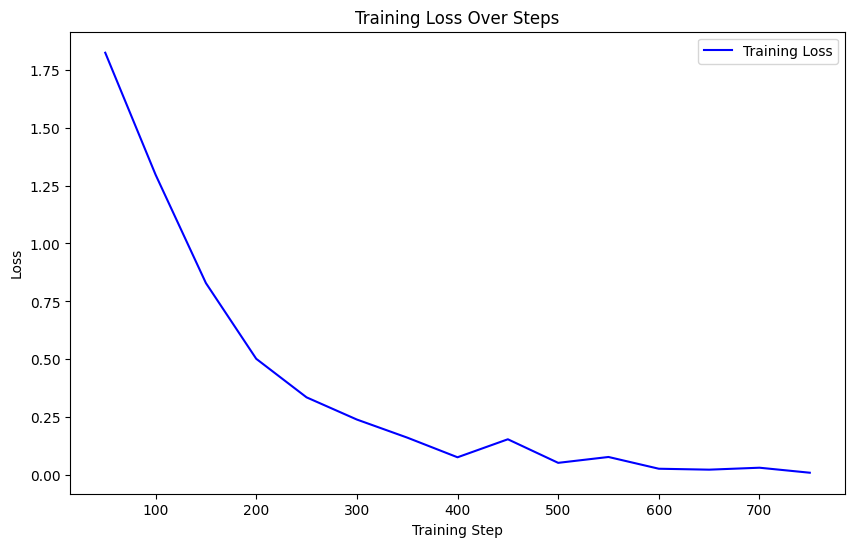

In [62]:
plt.figure(figsize=(10, 6))
plt.plot(train_logs["step"], train_logs["loss"], label="Training Loss", color="blue")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training Loss Over Steps")
plt.legend()
plt.show()

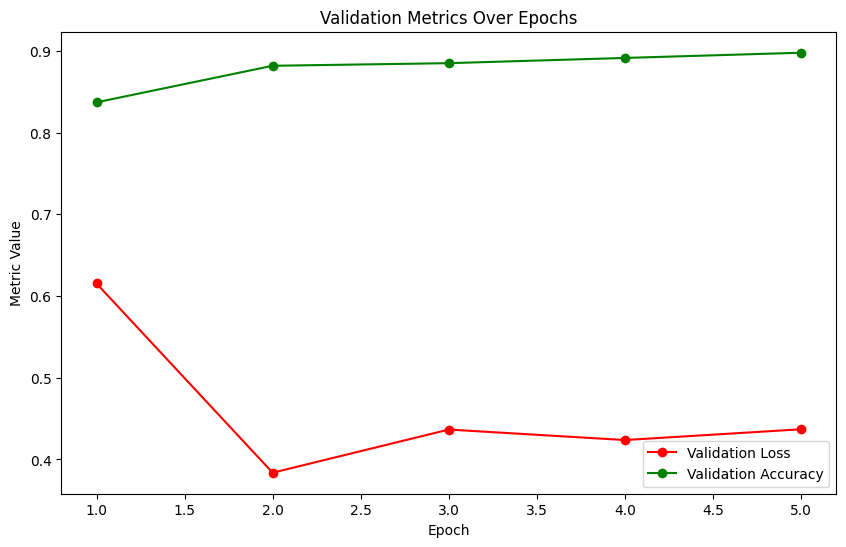

In [63]:
plt.figure(figsize=(10, 6))
plt.plot(
    eval_logs["epoch"],
    eval_logs["eval_loss"],
    marker="o",
    label="Validation Loss",
    color="red",
)
plt.plot(
    eval_logs["epoch"],
    eval_logs["eval_accuracy"],
    marker="o",
    label="Validation Accuracy",
    color="green",
)
plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.title("Validation Metrics Over Epochs")
plt.legend()
plt.show()

In [64]:
# Evaluate on validation set
val_metrics = trainer_roberta.evaluate(eval_dataset=val_dataset_roberta)
print("Validation metrics:", val_metrics)

# Evaluate on test set
test_metrics = trainer_roberta.evaluate(eval_dataset=test_dataset_roberta)
print("Test metrics:", test_metrics)

  0%|          | 0/40 [00:00<?, ?it/s]

Validation metrics: {'eval_loss': 0.49752384424209595, 'eval_accuracy': 0.9137380191693291, 'eval_f1': 0.9133080640980651, 'eval_runtime': 1.2213, 'eval_samples_per_second': 256.29, 'eval_steps_per_second': 32.753, 'epoch': 5.0}


  0%|          | 0/49 [00:00<?, ?it/s]

Test metrics: {'eval_loss': 0.4365498125553131, 'eval_accuracy': 0.9130434782608695, 'eval_f1': 0.9135741564654953, 'eval_runtime': 1.6001, 'eval_samples_per_second': 244.355, 'eval_steps_per_second': 30.622, 'epoch': 5.0}


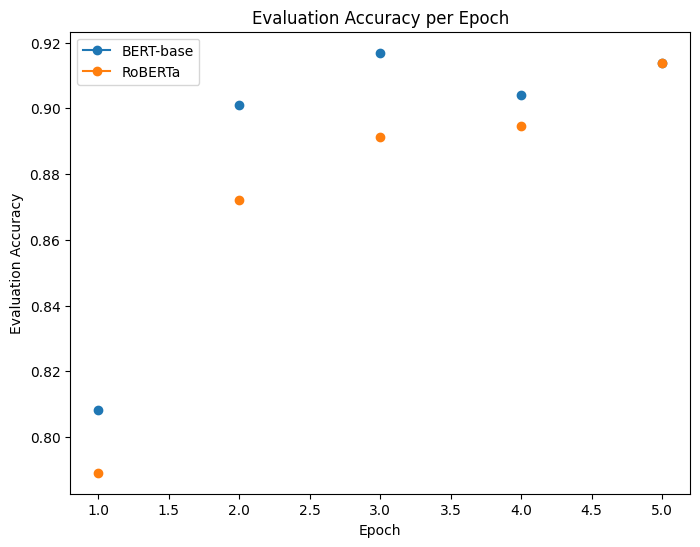

In [65]:
# accuracy over epochs

plt.figure(figsize=(8, 6))
plt.plot(
    bertbaselog["epoch"], bertbaselog["eval_accuracy"], marker="o", label="BERT-base"
)
plt.plot(robertalog["epoch"], robertalog["eval_accuracy"], marker="o", label="RoBERTa")
plt.xlabel("Epoch")
plt.ylabel("Evaluation Accuracy")
plt.title("Evaluation Accuracy per Epoch")
plt.legend()
plt.show()

  0%|          | 0/40 [00:00<?, ?it/s]

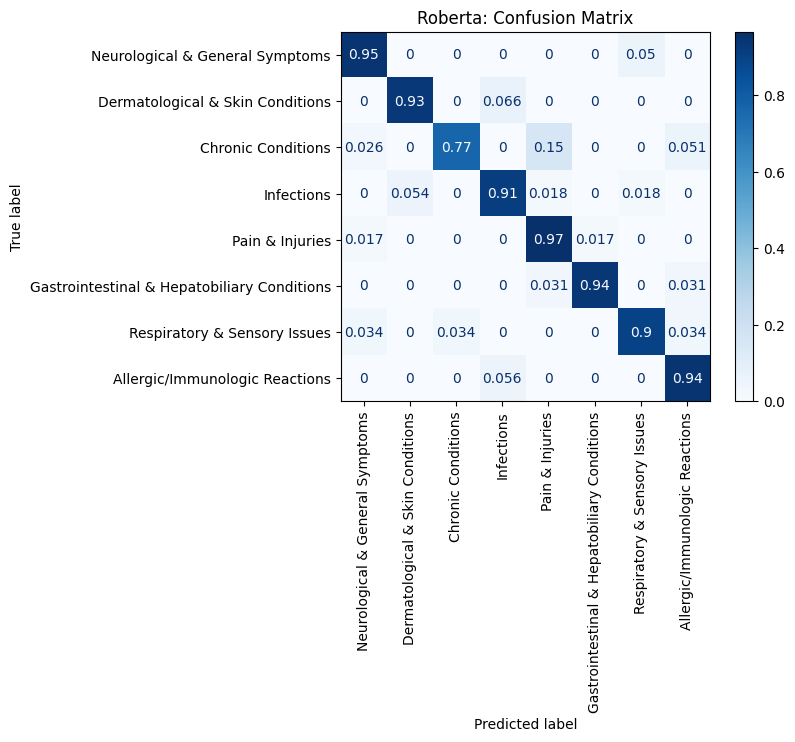

In [66]:
# Run the model on the validation set
predictions = trainer_roberta.predict(val_dataset_roberta)

# Get predicted and true labels
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize="true")
# normalize = true shows proportions instead of raw numbers

# Plot it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap="Blues", xticks_rotation=90)
plt.title("Roberta: Confusion Matrix")
plt.show()

# DistilBERT

## Tokenize the Text

In [67]:
tokenizer_distil = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")


def tokenize_function_distilbert(example):
    return tokenizer_roberta(example["phrase"], padding=True, truncation=True)

In [68]:
# apply the tokenizer to our data
train_dataset_distil = train_dataset_OG.map(tokenize_function_distilbert, batched=True)
val_dataset_distil = val_dataset_OG.map(tokenize_function_distilbert, batched=True)
test_dataset_distil = test_dataset_OG.map(tokenize_function_distilbert, batched=True)

# rename columns to the format Trainer expects
train_dataset_distil = train_dataset_distil.rename_column("label_id", "labels")
val_dataset_distil = val_dataset_distil.rename_column("label_id", "labels")
test_dataset_distil = test_dataset_distil.rename_column("label_id", "labels")

# set format to PyTorch tensors
train_dataset_distil.set_format(
    "torch", columns=["input_ids", "attention_mask", "labels"]
)
val_dataset_distil.set_format(
    "torch", columns=["input_ids", "attention_mask", "labels"]
)
test_dataset_distil.set_format(
    "torch", columns=["input_ids", "attention_mask", "labels"]
)

Map:   0%|          | 0/1248 [00:00<?, ? examples/s]

Map:   0%|          | 0/313 [00:00<?, ? examples/s]

Map:   0%|          | 0/391 [00:00<?, ? examples/s]

## Define the Model

In [69]:
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=len(unique_labels)
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training

In [70]:
# defining the training hyperparams
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",  # Evaluate every epoch
    save_strategy="epoch",  # Save checkpoint every epoch
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,  # Adjust based on dataset size
    weight_decay=0.01,
    logging_steps=50,
)


# evaluation function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")
    return {"accuracy": acc, "f1": f1}


data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
# for padding

# initialize the trainer
trainer_distilbert = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_distil,
    eval_dataset=val_dataset_distil,
    tokenizer=tokenizer_distil,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

# now we actually trian
trainer_distilbert.train()

/Users/kaylahaeusssler/miniforge3/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/bs/tlrmg2n164520pry59rs7fvh0000gn/T/ipykernel_50087/3240400859.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_distilbert = Trainer(


  0%|          | 0/780 [00:00<?, ?it/s]

{'loss': 2.0276, 'grad_norm': 3.782775402069092, 'learning_rate': 4.67948717948718e-05, 'epoch': 0.32}
{'loss': 1.993, 'grad_norm': 3.8909668922424316, 'learning_rate': 4.358974358974359e-05, 'epoch': 0.64}
{'loss': 1.8494, 'grad_norm': 4.161191940307617, 'learning_rate': 4.038461538461539e-05, 'epoch': 0.96}


  0%|          | 0/40 [00:00<?, ?it/s]

{'eval_loss': 1.7990789413452148, 'eval_accuracy': 0.3258785942492013, 'eval_f1': 0.2115597535937867, 'eval_runtime': 0.7519, 'eval_samples_per_second': 416.287, 'eval_steps_per_second': 53.2, 'epoch': 1.0}
{'loss': 1.7462, 'grad_norm': 8.761630058288574, 'learning_rate': 3.717948717948718e-05, 'epoch': 1.28}
{'loss': 1.6332, 'grad_norm': 14.963107109069824, 'learning_rate': 3.397435897435898e-05, 'epoch': 1.6}
{'loss': 1.5525, 'grad_norm': 15.644670486450195, 'learning_rate': 3.0769230769230774e-05, 'epoch': 1.92}


  0%|          | 0/40 [00:00<?, ?it/s]

{'eval_loss': 1.4270305633544922, 'eval_accuracy': 0.4440894568690096, 'eval_f1': 0.3864105885928403, 'eval_runtime': 0.7297, 'eval_samples_per_second': 428.967, 'eval_steps_per_second': 54.82, 'epoch': 2.0}
{'loss': 1.4098, 'grad_norm': 11.42147445678711, 'learning_rate': 2.756410256410257e-05, 'epoch': 2.24}
{'loss': 1.2039, 'grad_norm': 18.120956420898438, 'learning_rate': 2.435897435897436e-05, 'epoch': 2.56}
{'loss': 1.213, 'grad_norm': 12.940083503723145, 'learning_rate': 2.1153846153846154e-05, 'epoch': 2.88}


  0%|          | 0/40 [00:00<?, ?it/s]

{'eval_loss': 1.1205878257751465, 'eval_accuracy': 0.6357827476038339, 'eval_f1': 0.6211998877032565, 'eval_runtime': 0.7269, 'eval_samples_per_second': 430.609, 'eval_steps_per_second': 55.03, 'epoch': 3.0}
{'loss': 0.9908, 'grad_norm': 14.906913757324219, 'learning_rate': 1.794871794871795e-05, 'epoch': 3.21}
{'loss': 0.9387, 'grad_norm': 11.500214576721191, 'learning_rate': 1.4743589743589745e-05, 'epoch': 3.53}
{'loss': 0.7869, 'grad_norm': 23.68580436706543, 'learning_rate': 1.153846153846154e-05, 'epoch': 3.85}


  0%|          | 0/40 [00:00<?, ?it/s]

{'eval_loss': 1.0127745866775513, 'eval_accuracy': 0.6773162939297125, 'eval_f1': 0.6859769017755399, 'eval_runtime': 0.7127, 'eval_samples_per_second': 439.193, 'eval_steps_per_second': 56.127, 'epoch': 4.0}
{'loss': 0.5811, 'grad_norm': 10.779945373535156, 'learning_rate': 8.333333333333334e-06, 'epoch': 4.17}
{'loss': 0.5637, 'grad_norm': 10.946640014648438, 'learning_rate': 5.128205128205128e-06, 'epoch': 4.49}
{'loss': 0.525, 'grad_norm': 21.111459732055664, 'learning_rate': 1.9230769230769234e-06, 'epoch': 4.81}


  0%|          | 0/40 [00:00<?, ?it/s]

{'eval_loss': 0.9580901861190796, 'eval_accuracy': 0.6964856230031949, 'eval_f1': 0.7019114703853601, 'eval_runtime': 0.746, 'eval_samples_per_second': 419.577, 'eval_steps_per_second': 53.62, 'epoch': 5.0}
{'train_runtime': 55.1858, 'train_samples_per_second': 113.073, 'train_steps_per_second': 14.134, 'train_loss': 1.237424026391445, 'epoch': 5.0}


TrainOutput(global_step=780, training_loss=1.237424026391445, metrics={'train_runtime': 55.1858, 'train_samples_per_second': 113.073, 'train_steps_per_second': 14.134, 'total_flos': 109794103511040.0, 'train_loss': 1.237424026391445, 'epoch': 5.0})

In [71]:
distilBERTlog = pd.DataFrame(trainer_distilbert.state.log_history)

## Evaluate and Testing

In [72]:
# Training logs: rows that have a "loss" value (they won't have eval metrics)
train_logs = distilBERTlog[distilBERTlog["loss"].notna()]

# Evaluation logs: rows that have evaluation metrics (e.g., eval_loss)
eval_logs = distilBERTlog[distilBERTlog["eval_loss"].notna()]

In [73]:
# Evaluate on validation set
val_metrics = trainer_distilbert.evaluate(eval_dataset=val_dataset_distil)
print("Validation metrics:", val_metrics)

# Evaluate on test set
test_metrics = trainer_distilbert.evaluate(eval_dataset=test_dataset_distil)
print("Test metrics:", test_metrics)

  0%|          | 0/40 [00:00<?, ?it/s]

Validation metrics: {'eval_loss': 0.9580901861190796, 'eval_accuracy': 0.6964856230031949, 'eval_f1': 0.7019114703853601, 'eval_runtime': 0.9138, 'eval_samples_per_second': 342.528, 'eval_steps_per_second': 43.774, 'epoch': 5.0}


  0%|          | 0/49 [00:00<?, ?it/s]

Test metrics: {'eval_loss': 0.9006246328353882, 'eval_accuracy': 0.7161125319693095, 'eval_f1': 0.7201144338202219, 'eval_runtime': 0.9428, 'eval_samples_per_second': 414.729, 'eval_steps_per_second': 51.974, 'epoch': 5.0}


  0%|          | 0/40 [00:00<?, ?it/s]

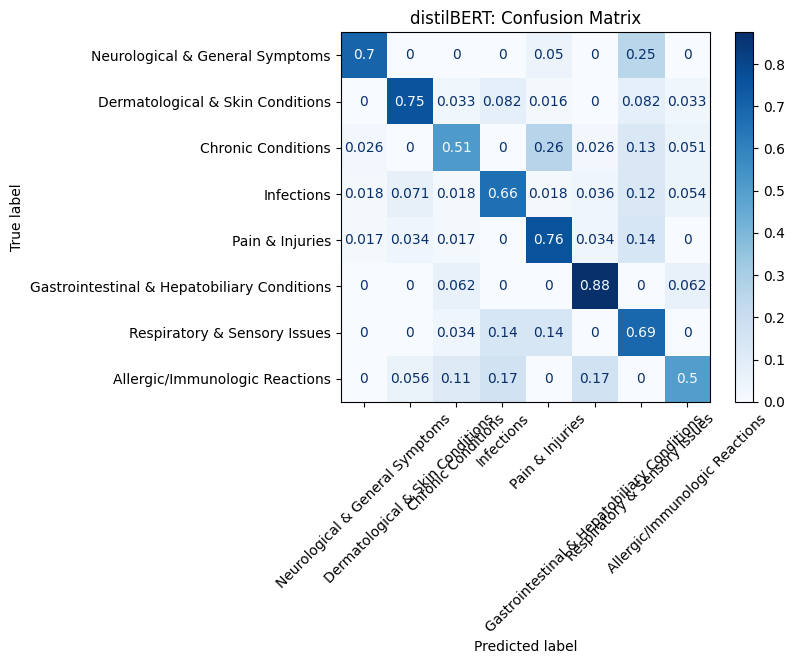

In [75]:
# Run the model on the validation set
predictions = trainer_distilbert.predict(val_dataset_distil)

# Get predicted and true labels
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize="true")
# normalize = true shows proportions instead of raw numbers

# Plot it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("distilBERT: Confusion Matrix")
plt.show()

# BioBERT

## Tokenize the Text

In [ ]:
tokenizer_distil = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")


def tokenize_function_distilbert(example):
    return tokenizer_roberta(example["phrase"], padding=True, truncation=True)

In [ ]:
# apply the tokenizer to our data
train_dataset_distil = train_dataset_OG.map(tokenize_function_distilbert, batched=True)
val_dataset_distil = val_dataset_OG.map(tokenize_function_distilbert, batched=True)
test_dataset_distil = test_dataset_OG.map(tokenize_function_distilbert, batched=True)

# rename columns to the format Trainer expects
train_dataset_distil = train_dataset_distil.rename_column("label_id", "labels")
val_dataset_distil = val_dataset_distil.rename_column("label_id", "labels")
test_dataset_distil = test_dataset_distil.rename_column("label_id", "labels")

# set format to PyTorch tensors
train_dataset_distil.set_format(
    "torch", columns=["input_ids", "attention_mask", "labels"]
)
val_dataset_distil.set_format(
    "torch", columns=["input_ids", "attention_mask", "labels"]
)
test_dataset_distil.set_format(
    "torch", columns=["input_ids", "attention_mask", "labels"]
)

# MODEL COMPARISON

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

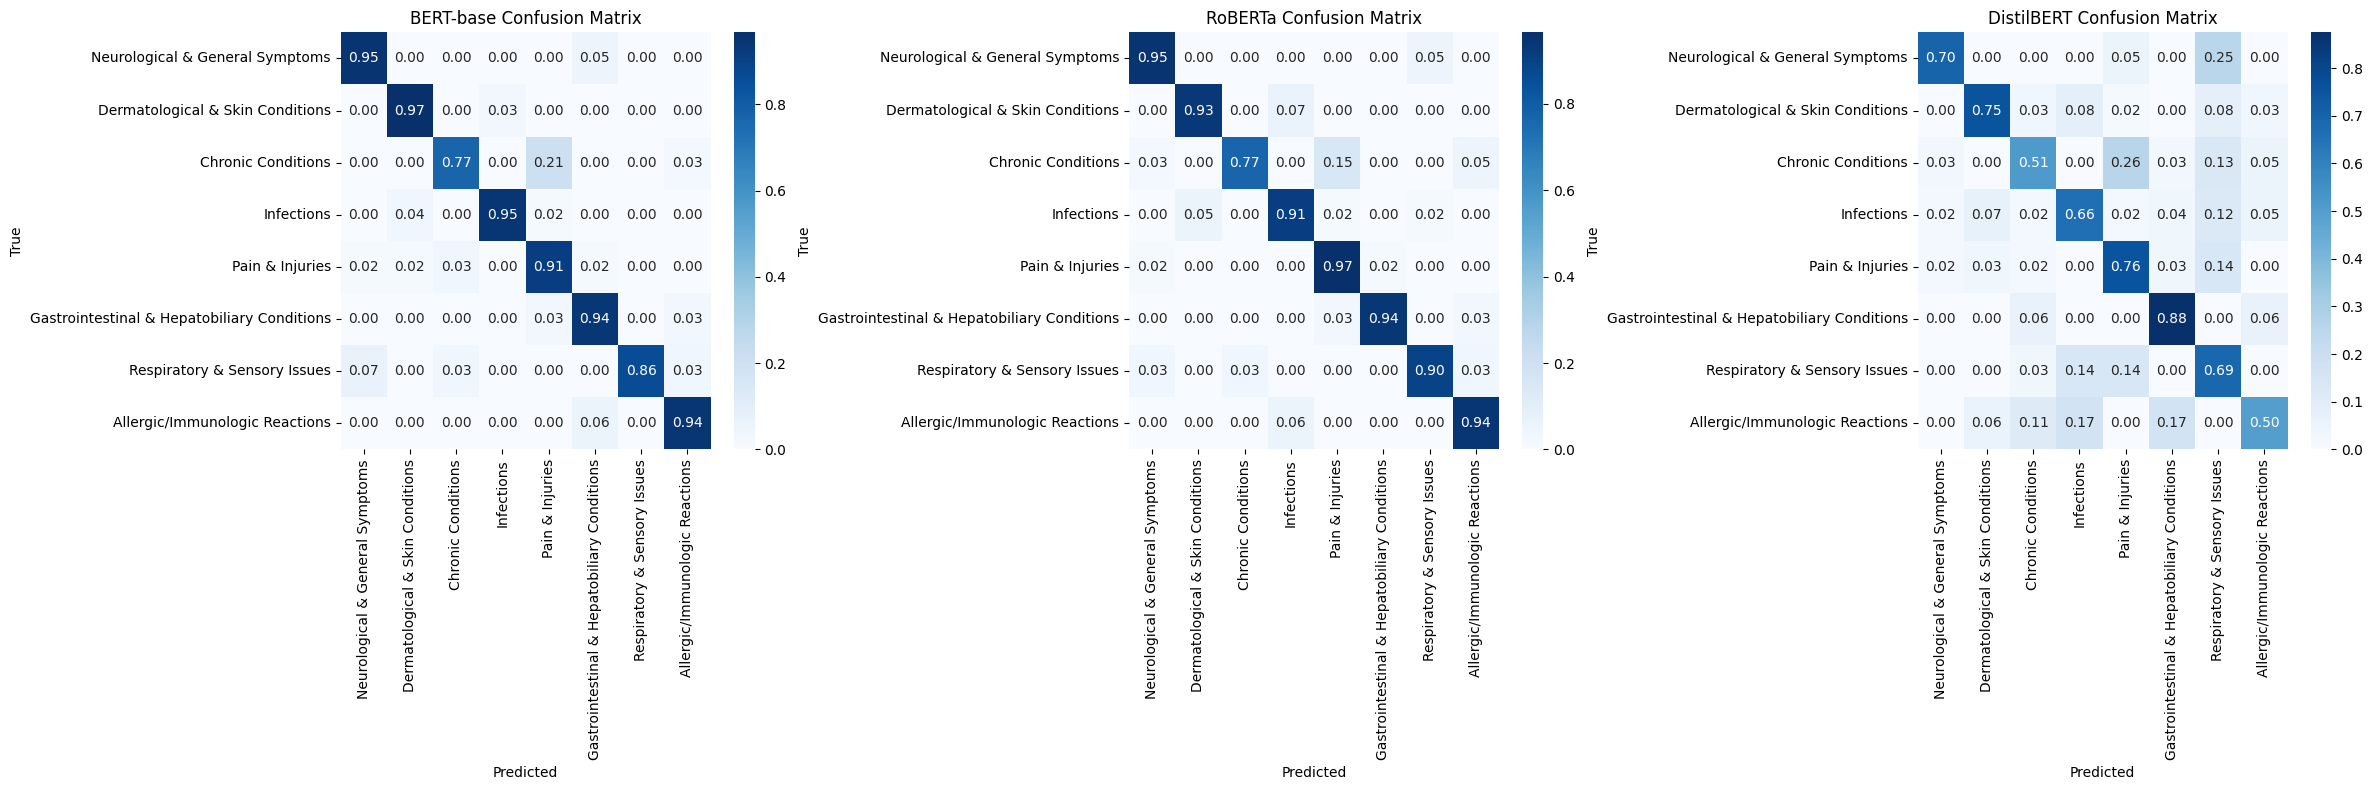

In [76]:
# ---- Step 1: Get predictions ----
preds_bertbase = trainer_bertbase.predict(val_dataset_bert)
y_pred_bertbase = np.argmax(preds_bertbase.predictions, axis=1)

preds_roberta = trainer_roberta.predict(val_dataset_roberta)
y_pred_roberta = np.argmax(preds_roberta.predictions, axis=1)

preds_distilbert = trainer_distilbert.predict(val_dataset_distil)
y_pred_distilbert = np.argmax(preds_distilbert.predictions, axis=1)

y_true = preds_roberta.label_ids  # Same for all models

# ---- Step 2: Confusion matrices ----
cm_bertbase = confusion_matrix(y_true, y_pred_bertbase, normalize="true")
cm_roberta = confusion_matrix(y_true, y_pred_roberta, normalize="true")
cm_distilbert = confusion_matrix(y_true, y_pred_distilbert, normalize="true")

# ---- Step 3: Side-by-side plot ----
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
sns.heatmap(
    cm_bertbase,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=unique_labels,
    yticklabels=unique_labels,
    ax=axes[0],
)
axes[0].set_title("BERT-base Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")


sns.heatmap(
    cm_roberta,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=unique_labels,
    yticklabels=unique_labels,
    ax=axes[1],
)
axes[1].set_title("RoBERTa Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

sns.heatmap(
    cm_distilbert,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=unique_labels,
    yticklabels=unique_labels,
    ax=axes[2],
)
axes[2].set_title("DistilBERT Confusion Matrix")
axes[2].set_xlabel("Predicted")
axes[2].set_ylabel("True")

plt.tight_layout()
plt.show()

In [77]:
from sklearn.metrics import precision_score, recall_score, f1_score

# ---- Overall precision/recall/f1 (BERT-base) ----
bertbase_precision = precision_score(
    y_true, y_pred_bertbase, average="weighted", zero_division=0
)
bertbase_recall = recall_score(
    y_true, y_pred_bertbase, average="weighted", zero_division=0
)
bertbase_f1 = f1_score(y_true, y_pred_bertbase, average="weighted", zero_division=0)
print(
    "\n🔹 BERT-base: Precision =",
    bertbase_precision,
    "| Recall =",
    bertbase_recall,
    "| F1 =",
    bertbase_f1,
)

# ---- Overall precision/recall/f1 (RoBERTa) ----
roberta_precision = precision_score(
    y_true, y_pred_roberta, average="weighted", zero_division=0
)
roberta_recall = recall_score(
    y_true, y_pred_roberta, average="weighted", zero_division=0
)
roberta_f1 = f1_score(y_true, y_pred_roberta, average="weighted", zero_division=0)
print(
    "\n🔹 RoBERTa: Precision =",
    roberta_precision,
    "| Recall =",
    roberta_recall,
    "| F1 =",
    roberta_f1,
)

# ---- Overall precision/recall/f1 (DistilBERT) ----
distil_precision = precision_score(
    y_true, y_pred_distilbert, average="weighted", zero_division=0
)
distil_recall = recall_score(
    y_true, y_pred_distilbert, average="weighted", zero_division=0
)
distil_f1 = f1_score(y_true, y_pred_distilbert, average="weighted", zero_division=0)
print(
    "\n🔹 DistilBERT: Precision =",
    distil_precision,
    "| Recall =",
    distil_recall,
    "| F1 =",
    distil_f1,
)


🔹 BERT-base: Precision = 0.9166896360135564 | Recall = 0.9137380191693291 | F1 = 0.9134138488164462

🔹 RoBERTa: Precision = 0.9175156699427544 | Recall = 0.9137380191693291 | F1 = 0.9133080640980651

🔹 DistilBERT: Precision = 0.7217929870102902 | Recall = 0.6964856230031949 | F1 = 0.7019114703853601


In [78]:
# ---- Per-class precision/recall/f1 (Bert Base) ----
precision, recall, f1, _ = precision_recall_fscore_support(
    y_true, y_pred_bertbase, average=None, zero_division=0
)
prf_df = pd.DataFrame(
    {"Label": unique_labels, "Precision": precision, "Recall": recall, "F1 Score": f1}
).sort_values("F1 Score", ascending=True)

print("\n📋 Per-Class Precision/Recall/F1 (Bert Base):")
print(prf_df)

# ---- Per-class precision/recall/f1 (RoBERTa) ----
precision, recall, f1, _ = precision_recall_fscore_support(
    y_true, y_pred_roberta, average=None, zero_division=0
)
prf_df = pd.DataFrame(
    {"Label": unique_labels, "Precision": precision, "Recall": recall, "F1 Score": f1}
).sort_values("F1 Score", ascending=True)

print("\n📋 Per-Class Precision/Recall/F1 (RoBERTa):")
print(prf_df)

# ---- Per-class precision/recall/f1 (distilBERT) ----
precision, recall, f1, _ = precision_recall_fscore_support(
    y_true, y_pred_distilbert, average=None, zero_division=0
)
prf_df = pd.DataFrame(
    {"Label": unique_labels, "Precision": precision, "Recall": recall, "F1 Score": f1}
).sort_values("F1 Score", ascending=True)

print("\n📋 Per-Class Precision/Recall/F1 (distilBERT):")
print(prf_df)


📋 Per-Class Precision/Recall/F1 (Bert Base):
                                         Label  Precision    Recall  F1 Score
2                           Chronic Conditions   0.909091  0.769231  0.833333
4                              Pain & Injuries   0.841270  0.913793  0.876033
7               Allergic/Immunologic Reactions   0.850000  0.944444  0.894737
0              Neurological & General Symptoms   0.863636  0.950000  0.904762
5  Gastrointestinal & Hepatobiliary Conditions   0.909091  0.937500  0.923077
6                 Respiratory & Sensory Issues   1.000000  0.862069  0.925926
3                                   Infections   0.963636  0.946429  0.954955
1             Dermatological & Skin Conditions   0.951613  0.967213  0.959350

📋 Per-Class Precision/Recall/F1 (RoBERTa):
                                         Label  Precision    Recall  F1 Score
2                           Chronic Conditions   0.967742  0.769231  0.857143
7               Allergic/Immunologic Reactions   0.8

In [79]:
# ---- Most confused pairs (Bert Base) ----
cm_temp = cm_bertbase.copy()
np.fill_diagonal(cm_temp, 0)  # remove correct predictions
flat = cm_temp.flatten()
top_indices = flat.argsort()[-5:][::-1]
rows, cols = np.unravel_index(top_indices, cm_temp.shape)

print("\n😵 Most Confused Class Pairs (Bert base):")
for r, c in zip(rows, cols):
    print(f"  '{unique_labels[r]}' → '{unique_labels[c]}' = {cm_temp[r, c]} times")

# ---- Most confused pairs (RoBERTa) ----
cm_temp = cm_roberta.copy()
np.fill_diagonal(cm_temp, 0)  # remove correct predictions
flat = cm_temp.flatten()
top_indices = flat.argsort()[-5:][::-1]
rows, cols = np.unravel_index(top_indices, cm_temp.shape)

print("\n😵 Most Confused Class Pairs (RoBERTa):")
for r, c in zip(rows, cols):
    print(f"  '{unique_labels[r]}' → '{unique_labels[c]}' = {cm_temp[r, c]} times")


# ---- Most confused pairs (distilBERT) ----
cm_temp = cm_distilbert.copy()
np.fill_diagonal(cm_temp, 0)  # remove correct predictions
flat = cm_temp.flatten()
top_indices = flat.argsort()[-5:][::-1]
rows, cols = np.unravel_index(top_indices, cm_temp.shape)

print("\n😵 Most Confused Class Pairs (distilBERT):")
for r, c in zip(rows, cols):
    print(f"  '{unique_labels[r]}' → '{unique_labels[c]}' = {cm_temp[r, c]} times")


😵 Most Confused Class Pairs (Bert base):
  'Chronic Conditions' → 'Pain & Injuries' = 0.20512820512820512 times
  'Respiratory & Sensory Issues' → 'Neurological & General Symptoms' = 0.06896551724137931 times
  'Allergic/Immunologic Reactions' → 'Gastrointestinal & Hepatobiliary Conditions' = 0.05555555555555555 times
  'Neurological & General Symptoms' → 'Gastrointestinal & Hepatobiliary Conditions' = 0.05 times
  'Infections' → 'Dermatological & Skin Conditions' = 0.03571428571428571 times

😵 Most Confused Class Pairs (RoBERTa):
  'Chronic Conditions' → 'Pain & Injuries' = 0.15384615384615385 times
  'Dermatological & Skin Conditions' → 'Infections' = 0.06557377049180328 times
  'Allergic/Immunologic Reactions' → 'Infections' = 0.05555555555555555 times
  'Infections' → 'Dermatological & Skin Conditions' = 0.05357142857142857 times
  'Chronic Conditions' → 'Allergic/Immunologic Reactions' = 0.05128205128205128 times

😵 Most Confused Class Pairs (distilBERT):
  'Chronic Conditions' →